In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import scipy.stats as stats
# # 
import warnings
# 
# import arviz as az
# import pymc as pm
# import theano.tensor as tt

In [20]:
class A_dist():
    def __init__(self, beta_hat = None):
        self.beta = 1 if beta_hat == None else beta_hat
        # self.beta_hat = 0
        self.df = pd.DataFrame(columns = ['beta', 'beta_hat', 'sample_size', 'initial_guess'])
        self.result = pd.DataFrame()
    
    def pdf(self, x):
        if(x <= 0): return 0
            
        c = self.beta/x
        if(c > 10): return 0
        pdf = (x**-2) * np.exp(((1 - np.exp(c))/self.beta) + c)

        return pdf

        
    def cdf(self, x):
        if(x <= 0): return 0

        c = self.beta/x
        if(c > 10): return 0
        # cdf = np.exp((1 - np.exp(c))/self.beta)
        log_cdf = (1 - np.exp(c))/(self.beta)
        return np.exp(log_cdf)
    
    def cdf_call(self, x):
        result = np.zeros_like(x)  # Initialize an array for storing results
        mask_positive = x > 0  # Create a mask for positive values

        c = self.beta / x[mask_positive]
        log_cdf = (1 - np.exp(c)) / self.beta
        result[mask_positive] = np.exp(log_cdf)
        return result

        
    def plot(self):
        fig, axs = plt.subplots(1, 2, figsize=(15,7))
        tolerance = 10**-2

        ax = axs[0]

        x = np.linspace(10**-5, 30, 1000)     
        ax.plot(x, [self.pdf(value) for value in x])
        ax.set_title('PDF')
        
        ax = axs[1]
        lim_sup = 1
        while((1 - self.cdf(lim_sup)) > tolerance): lim_sup+=1
    
        x = np.linspace(10**-5, lim_sup, 1000)     
        ax.plot(x, [self.cdf(value) for value in x])
        ax.set_title('CDF')
        plt.show()
        
    
    def MLE(self, x_values, **kwargs):
        initial_guess = kwargs['initial_guess']
        def estimator(beta):
            sum_X = sum(x**-1 for x in x_values)
            sum_numerator = sum(((beta/x) * np.exp(beta/x)) - np.exp(beta/x) + 1 for x in x_values)
            return sum_X - sum_numerator / (beta**2)
    
        result = fsolve(func=estimator, x0=initial_guess, xtol = 1e-7, maxfev = 1000)

        while result[0] < 0:
            x_values = self.exp_sample(n = len(x_values))
            result = fsolve(func=estimator, x0=initial_guess, xtol = 1e-7, maxfev = 1000)

        return result[0]
    
    def LL(self, x_values, **kwargs):
        beta_hat = kwargs['beta_hat']

        sum_X =   sum(x**-1 for x in x_values)
        sum_numerator = sum(np.exp(beta_hat/x) - 1 for x in x_values)
        sum_ln = sum(np.log(x) for x in x_values)
        return (beta_hat * sum_X) - (sum_numerator / beta_hat) - (2 * sum_ln)


    def exp_sample(self, n = 10):
        x = []
        for i in range(n):
            u = np.random.random()
            value = self.beta/np.log(1 - (self.beta* np.log(u)))
            while(value > 100):
                u = np.random.random()
                value = self.beta/np.log(1 - (self.beta* np.log(u)))
            x.append(value)
        return x

    def plot_sample(self, n = 10, lim_sup = 100, **kwargs):
        sample = self.exp_sample(n = n)
        fig, ax = plt.subplots(1, 1, figsize=(15,7))
        
        plt.hist(sample, bins = int(n/2), density=True, alpha=0.5, color='blue', label='Generated Data')
        # lim_sup = max(sample)

        x = np.linspace(0, lim_sup, 1000)
        pdf = [self.pdf(value) for value in x]
        
        plt.plot(x, pdf, color='red', label='Theoretical PDF')
        
        ax.set_xlim(0,100)
        plt.xlabel('Random Variable')
        plt.ylabel('Probability Density')
        plt.title('Random Variables using Inverse Transformation')
        plt.legend()
        plt.grid(True)
        
        plt.show()
        
        beta_hat = self.MLE(x_values = sample, **kwargs)
        print(f"Valor estimado para beta:{beta_hat:.2f}")
        
        return sample

    def run_experiment(self, true_params : list, sample_sizes : list, n_rep : int, initial_guess : list):
        for param in true_params:
            self.beta = param
            for sample_size in sample_sizes:
                for guess in initial_guess:
                    for rep in range(n_rep):
                        sample = self.exp_sample(n = sample_size)
                        beta_hat = self.MLE(x_values = sample, initial_guess = guess)
                        self.df.loc[len(self.df)] = [param, beta_hat, sample_size, guess]
    
                        
            self.result = self.df.groupby(['sample_size', 'initial_guess'])['beta_hat'].agg(['mean', 'std']).reset_index()

    def plot_experiment(self, true_param, applyGap = True):
        fig, axs = plt.subplots(1, 2, figsize = (15,7))
        
        ax = axs[1]
        for i, guess in enumerate(self.result['initial_guess'].unique()):
            data = self.result.loc[(self.result['initial_guess'] == guess) & (self.result['beta'] == true_param)]     
            plt.errorbar(data['sample_size'] + i*(5 if applyGap else 0), data['mean'], yerr=data['std'], fmt='-o', capsize=5, label = guess)
        
        ax.legend()
        ax.set_title(f"Estimation of the Beta parameter - True value = {self.beta}")
        ax.set_xlabel('Sample Size')
        ax.set_ylabel('Beta_hat')
        
        ax = axs[0]
        ax = fig.add_subplot(111, projection='3d')
        for i, guess in enumerate(self.result['initial_guess'].unique()):
            data = self.result.loc[(self.result['initial_guess'] == guess) & (self.result['beta'] == true_param)]
            ax.plot(data['sample_size'], [guess] * len(data), data['mean'], label=f'Initial Guess {guess}', marker='o')
    
        ax.set_xlabel('Sample Size')
        ax.set_ylabel('Initial Guess')
        ax.set_zlabel('Beta_hat')
        ax.legend()
    
        # ax.set_title(f"Estimation of the Beta parameter - True value = {self.beta}")
        ax.set_title("TEM QUE TIRAR A CAIXA AO REDOR DO PLOT!")
        plt.tight_layout()
        plt.show()

# Simulação

In [6]:
rep = 1000
initial_guess = [0.50, 0.75, 1, 2, 5]

a = A_dist()
a.run_experiment(true_params = [0.125, 0.60, 1], sample_sizes = [20, 50, 100,  400], initial_guess=initial_guess, n_rep = rep)

C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [10]:
a.df

,beta,beta_hat,sample_size,initial_guess
0,0.125,0.498168,20.0,0.5
1,0.125,0.192065,20.0,0.5
2,0.125,0.577071,20.0,0.5
3,0.125,0.379211,20.0,0.5
4,0.125,0.072842,20.0,0.5
...,...,...,...,...
59995,1.000,0.889355,400.0,5.0
59996,1.000,1.032176,400.0,5.0
59997,1.000,1.040564,400.0,5.0
59998,1.000,1.069459,400.0,5.0


In [12]:
df_teste = a.df.copy()
df_teste['mse'] = (df_teste['beta'] - df_teste['beta_hat'])**2

mse_sum = df_teste.groupby(['initial_guess', 'sample_size', 'beta' ])['mse'].sum()
mse_sum = mse_sum.drop(columns = 'initial_guess').groupby(['sample_size', 'beta']).sum() / (rep * len(initial_guess))

grouped = df_teste.groupby(['sample_size', 'beta'])['beta_hat'].agg(['mean', 'std', 'var']).reset_index()

result = pd.merge(grouped, mse_sum, on=['sample_size', 'beta'])
result['bias'] = abs(result['beta'] - result['mean'])
result.head(15)

,sample_size,beta,mean,std,var,mse,bias
0,20.0,0.125,0.281641,0.240518,0.057849,0.082374,0.156641
1,20.0,0.600,0.721813,0.315449,0.099508,0.114327,0.121813
2,20.0,1.000,1.134351,0.366593,0.134390,0.152414,0.134351
3,50.0,0.125,0.182552,0.125260,0.015690,0.018999,0.057552
4,50.0,0.600,0.640417,0.176382,0.031111,0.032738,0.040417
5,50.0,1.000,1.045508,0.206936,0.042823,0.044885,0.045508
6,100.0,0.125,0.150665,0.085874,0.007374,0.008032,0.025665
7,100.0,0.600,0.621466,0.118149,0.013959,0.014417,0.021466
8,100.0,1.000,1.024622,0.142050,0.020178,0.020780,0.024622
9,400.0,0.125,0.130342,0.041488,0.001721,0.001749,0.005342


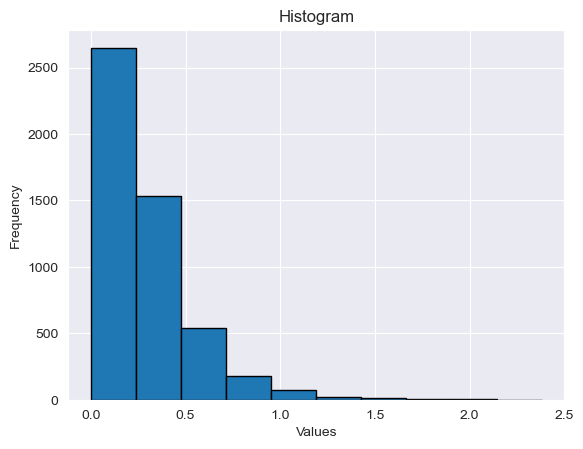

In [13]:
amostra = 20
beta_real = .125

df_hist = df_teste.loc[(df_teste['beta'] == beta_real) & (df_teste['sample_size'] == amostra)]
df_hist['beta_hat'].plot(kind='hist', bins=10, edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

In [14]:
z = stats.norm.ppf(0.975)
result_interval = result.loc[(result['beta'] == beta_real) & (result['sample_size'] == amostra)]
media = result_interval['mean'].iloc[0]
desvpad = result_interval['std'].iloc[0]

intervalo_conf = [media - z*desvpad, media + z*desvpad]
intervalo_conf

[-0.1897652066304984, 0.7530479999768827]

In [15]:
cobertura = df_hist['beta_hat'].between(intervalo_conf[0], intervalo_conf[1]).sum() / len(df_hist['beta_hat'])
cobertura

0.9508

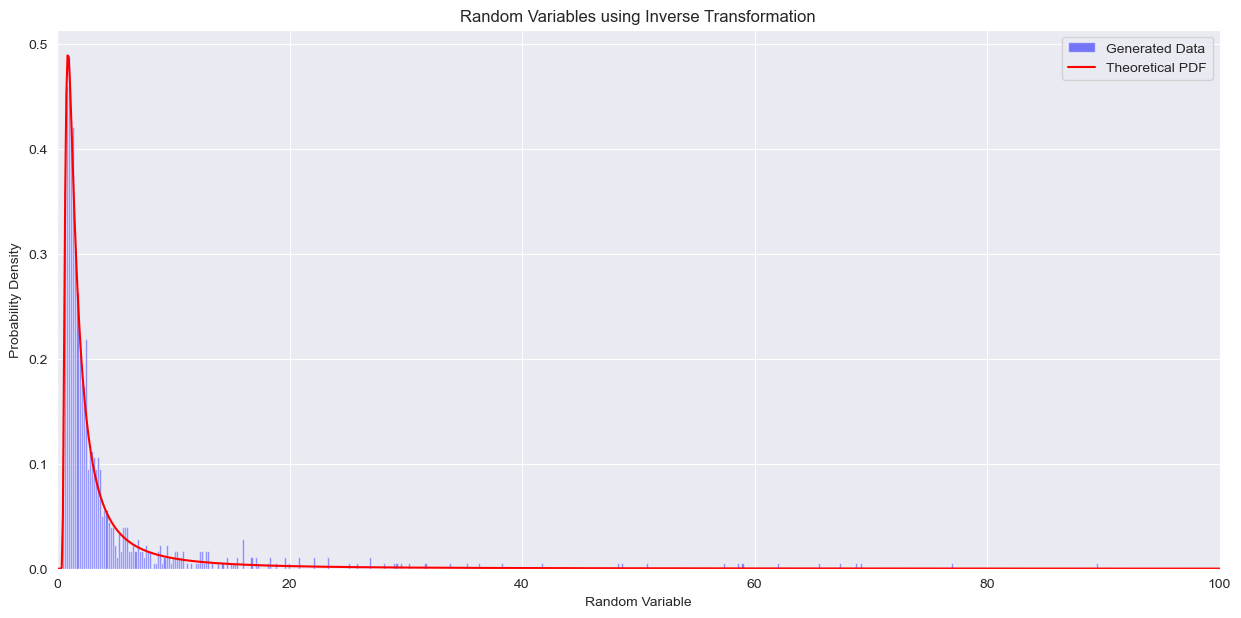

Valor estimado para beta:1.00


(1000, 89.52572733198595)

In [16]:
x = a.plot_sample(n=1000, lim_sup=100, initial_guess = 100)
len(x), max(x)

# Amostra real

In [18]:
sample_real = [18.83, 20.8, 21.657, 23.03, 23.23, 24.05, 24.321, 25.5, 25.52, 25.8, 26.69, 26.77, 26.78, 27.05, 27.67, 29.9, 31.11, 33.2, 33.73, 33.76, 33.89, 34.76, 35.75, 35.91, 36.98, 37.08, 37.09, 39.58, 44.045, 45.29, 45.381]

df_result = pd.DataFrame(columns = ['initial_guess', 'MLE', 'LL', 'AIC', 'BIC'])

for i in range(1, 1000, 100):
    results_mle = []
    results_ll = []
    for j in range(5):
        results_mle.append(a.MLE(sample_real, initial_guess = i))
        b_hat = sum(results_mle) / len(results_mle)
        results_ll.append(a.LL(sample_real, beta_hat = b_hat))  
    
    mle = sum(results_mle) / len(results_mle)
    ll = sum(results_ll) / len(results_ll)
    df_result.loc[len(df_result)] = [i, mle, - ll,
                                     2 - 2*ll,
                                     np.log(len(sample_real)) - 2*ll] # como já convergiu para EMV ll é LL maximizada

df_result.iloc[:, 1:].mean()

MLE    125.662000
LL     107.950308
AIC    217.900616
BIC    219.334603
dtype: float64

In [21]:
EMV = df_result['MLE'].mean()
A_sample= A_dist(EMV)

ks_test = stats.kstest(sample_real, A_sample.cdf_call)
print(f"Estimador Máxima Vero:\t{EMV:.2f}\nKS-Test:\nEstatítica:\t\t\t\t{ks_test.statistic:.4f}\nP-valor:\t\t\t\t{ks_test.pvalue:.4f}")

Estimador Máxima Vero:	125.66
KS-Test:
Estatítica:				0.1616
P-valor:				0.3543
